# HSC Re-Run: Making Forced Photometry Light Curves from Scratch

<br>Owner: **Justin Myles** ([@jtmyles](https://github.com/LSSTScienceCollaborations/StackClub/issues/new?body=@jtmyles))
<br>Last Verified to Run: **2018-08-10**
<br>Verified Stack Release: **16.0**

This project addresses issue [#63: HSC Re-run](https://github.com/LSSTScienceCollaborations/StackClub/issues/63)

This notebook demonstrates the pipeline described in the [LSST Science Piplines data processing tutorial](https://pipelines.lsst.io/), from ingesting images (using the [obs_subaru](https://github.com/lsst/obs_subaru) package) through image processing, coaddition, source detection and object measurement all the way through to measuring forced photometry light curves in a small patch of the HSC sky (in the [ci_hsc](https://github.com/lsst/ci_hsc/) repository). 

### Learning Objectives:
After working through and studying this notebook you should be able to understand how to use the DRP pipeline from image visualization through to a forced photometry light curve. Specific learning objectives include: 
   1. [Configuring](https://pipelines.lsst.io/v/w-2018-12/modules/lsst.pipe.base/command-line-task-config-howto.html) and executing pipeline tasks in python as well as on the command line.
   2. The sequence of steps involved in the DRP pipeline.
   
Other techniques that are demonstrated, but not emphasized, in this notebook are
   1. Using the `butler` to fetch data
   2. Visualizing data with the LSST Stack

### Logistics
This notebook is intended to be runnable on `lsst-lspdev.ncsa.illinois.edu` from a local git clone of https://github.com/LSSTScienceCollaborations/StackClub.


## Set Up

In [ ]:
# todo: nb will point to processCcd.ipynb notebook on how to unpack a CL task
# todo: and will actually unpack processCcd, but not other tasks
# todo: then will make a few plots showing result of what we can do with processed images 

In [14]:
import os
os.system("eups list lsst_distrib") #todo
import sys
import matplotlib.pyplot as plt
%matplotlib inline
import eups.setupcmd

## Pipeline Preview

Before we unpack the pipeline described in the [LSST Science Piplines data processing tutorial](https://pipelines.lsst.io/), let's look at the complete set of command line tasks assembled into an end-to-end data reduction script.

In [1]:
! cat Re-RunHSC.sh

: 'HSC Re-Run: Making Forced Photometry Light Curves from Scratch
Owner: **Justin Myles** (@jtmyles)
Last Verified to Run: **2018-09-05**
Verified Stack Release: **16.0**

This project addresses issue #63: HSC Re-run

This shell script runs the command-line tasks from the tutorial at pipelines.lsst.io for analysis
from raw images through source detection and forced photometry measurements. It is intended as an 
intermediate step toward the end-goal of making a forced photometry lightcurve in the notebook at
StackClub/ImageProcessing/Re-RunHSC.ipynb

Recommended to run with 
$ bash Re-RunHSC.sh > output.txt
'


# Setup the LSST Stack
source /opt/lsst/software/stack/loadLSST.bash
eups list lsst_distrib
setup lsst_distrib


# I. Setting up the Butler data repository
date
echo "Re-RunHSC INFO: set up the Butler"

setup -j -r /project/shared/data/ci_hsc
DATADIR="/home/$USER/DATA"
mkdir -p "$DATADIR"

# A Butler needs a *mapper* file "to find and organize data in a format specific to each ca

We'll come back to each step in turn throughout the rest of this notebook.

## Part I: Interacting with data. Introduction to the Butler
https://pipelines.lsst.io/getting-started/data-setup.html

Part I runs the following command-line tasks
```
eups list lsst_distrib
setup -j -r /home/jmyles/repositories/ci_hsc
echo "lsst.obs.hsc.HscMapper" > /home/jmyles/DATA/_mapper
ingestImages.py /home/jmyles/DATA /home/jmyles/repositories/ci_hsc/raw/*.fits --mode=link
ln -s /home/jmyles/repositories/ci_hsc/CALIB/ /home/jmyles/DATA/CALIB
installTransmissionCurves.py /home/jmyles/DATA
mkdir -p /home/jmyles/DATA/ref_cats
ln -s /home/jmyles/repositories/ci_hsc/ps1_pv3_3pi_20170110 /home/jmyles/DATA/ref_cats/ps1_pv3_3pi_20170110
```

In [2]:
HOME = os.environ['HOME']
DATAREPO = "{}/repositories/ci_hsc/".format(HOME)
DATADIR = "{}/DATA/".format(HOME)
os.system("mkdir -p {}".format(DATADIR));

In [ ]:
#!setup -j -r /home/jmyles/repositories/ci_hsc

setup = eups.setupcmd.EupsSetup(["-j","-r", DATAREPO])
status = setup.run()
print('setup exited with status {}'.format(status))

A Butler needs a *mapper* file "to find and organize data in a format specific to each camera." We write this file to the data repository so that any instantiated Butler object knows which mapper to use.

In [ ]:
with open(DATADIR + "_mapper", "w") as f:
    f.write("lsst.obs.hsc.HscMapper")

In [ ]:
# ingest script
!ingestImages.py DATADIR /home/jmyles/repositories/ci_hsc/raw/*.fits --mode=link

In [ ]:
#!installTransmissionCurves.py /home/jmyles/DATA

from lsst.obs.hsc import makeTransmissionCurves, HscMapper
from lsst.daf.persistence import Butler

butler = Butler(outputs={'root': datadir, 'mode': 'rw', 'mapper': HscMapper})

for start, nested in makeTransmissionCurves.getFilterTransmission().items():
    for name, curve in nested.items():
        if curve is not None:
            butler.put(curve, "transmission_filter", filter=name)
for start, nested in makeTransmissionCurves.getSensorTransmission().items():
    for ccd, curve in nested.items():
        if curve is not None:
            butler.put(curve, "transmission_sensor", ccd=ccd)
for start, curve in makeTransmissionCurves.getOpticsTransmission().items():
    if curve is not None:
        butler.put(curve, "transmission_optics")
for start, curve in makeTransmissionCurves.getAtmosphereTransmission().items():
    if curve is not None:
        butler.put(curve, "transmission_atmosphere")

In [ ]:
# ingest calibration images into Butler repo
os.system("ln -s {} {}".format(datarepo + "CALIB/", datadir + "CALIB"))

# ingest reference catalog into Butler repo
os.system("mkdir -p {}".format(DATADIR + "ref_cats"))
os.system("ln -s {}ps1_pv3_3pi_20170110 {}ref_cats/ps1_pv3_3pi_20170110".format(DATAREPO, DATADIR))

# Part 2: Calibrating single frames
https://pipelines.lsst.io/getting-started/processccd.html

In [ ]:
"""
!processCcd.py DATA --rerun processCcdOutputs --id
# all cl tasks write output datasets to a Butler repo
# --rerun configured to write to processCcdOutputs
# other option is --output
"""

In [ ]:
!which processCcd.py
"""
processCcd.py
from lsst.pipe.tasks.processCcd import ProcessCcdTask

ProcessCcdTask.parseAndRun()
"""

In [ ]:
# show source of lsst.pipe.tasks.processCcd
# emacs /opt/lsst/software/stack/stack/miniconda3-4.3.21-10a4fa6/Linux64/pipe_tasks/16.0+1/python/lsst/pipe/tasks/processCcd.py


In [ ]:
from lsst.pipe.tasks.processCcd import ProcessCcdTask, ProcessCcdConfig
processCcdTaskInstance = ProcessCcdTask(butler=butler)

In [ ]:
from stackclub import where_is
where_is(processCcdTaskInstance, in_the="source")

In [ ]:
processCcdConfig = ProcessCcdConfig()

In [ ]:
"""
# review what data will be processed
!processCcd.py DATA --rerun processCcdOutputs --id --show data
# id allows you to select data by data ID
# unspecified id selects all raw data
# example IDs: raw, filter, visit, ccd, field
# show data turns on dry-run mode
"""

In [ ]:
#!which processCcd.py

# Part 3: Displaying exposures and source tables output by processCcd.py
https://pipelines.lsst.io/getting-started/display.html

This part of the tutorial is omitted for now.

# Part 4: Coadding images
https://pipelines.lsst.io/getting-started/coaddition.html

* A sky map is a tiling of the celestial sphere. It is composed of one or more tracts.
* A tract is composed of one or more overlapping patches. Each tract has a WCS.

In [ ]:
"""# make a discrete sky map that covers the exposures that have already been processed
!makeDiscreteSkyMap.py DATA --id --rerun processCcdOutputs:coadd --config skyMap.projection="TAN"

# the configuration field specifies the WCS Projection
# one of the FITS WCS projection codes, such as:
#           - STG: stereographic projection
#           - MOL: Molleweide's projection
#           - TAN: tangent-plane projection
"""

# Part 6: Multi-band catalog analysis
https://pipelines.lsst.io/getting-started/multiband-analysis.html

In [173]:
import os
import lsst.daf.persistence as dafPersist
butler = dafPersist.Butler(inputs=DATADIR + 'rerun/coaddForcedPhot/')

Access the sources identified from the coadd images

In [174]:
rSources = butler.get('deepCoadd_forced_src', {'filter': 'HSC-R', 'tract': 0, 'patch': '1,1'})
iSources = butler.get('deepCoadd_forced_src', {'filter': 'HSC-I', 'tract': 0, 'patch': '1,1'})
print(len(rSources))
print(len(iSources))

6800
6800


Throw out negative fluxes, and convert fluxes to magnitudes.

In [175]:
rCoaddCalib = butler.get('deepCoadd_calexp_calib',  {'filter': 'HSC-R', 'tract': 0, 'patch': '1,1'})
iCoaddCalib = butler.get('deepCoadd_calexp_calib',  {'filter': 'HSC-I', 'tract': 0, 'patch': '1,1'})

rCoaddCalib.setThrowOnNegativeFlux(False)
iCoaddCalib.setThrowOnNegativeFlux(False)

rMags = rCoaddCalib.getMagnitude(rSources['base_PsfFlux_flux'])
iMags = iCoaddCalib.getMagnitude(iSources['base_PsfFlux_flux'])

Select stars from catalog

In [176]:
deblended = rSources['deblend_nChild'] == 0

refTable = butler.get('deepCoadd_ref', {'filter': 'HSC-R^HSC-I', 'tract': 0, 'patch': '1,1'})
inInnerRegions = refTable['detect_isPatchInner'] & refTable['detect_isTractInner'] # define inner regions
isSkyObject = refTable['merge_peak_sky'] # reject sky objects
isPrimary = refTable['detect_isPrimary']

isStellar = iSources['base_ClassificationExtendedness_value'] < 1.
isGoodFlux = ~iSources['base_PsfFlux_flag']
selected = isPrimary & isStellar & isGoodFlux

Make color-magnitude diagram.

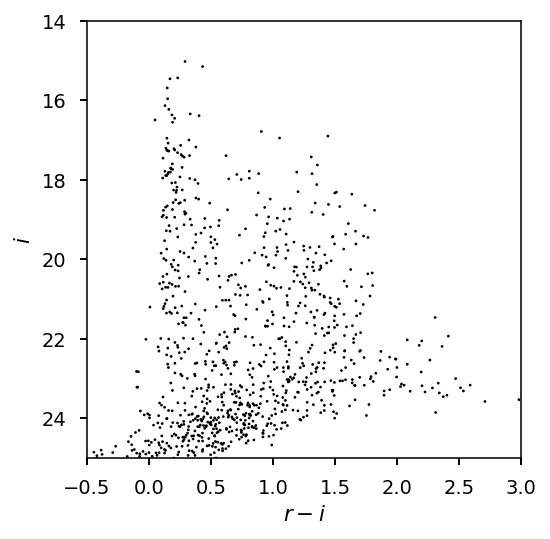

In [178]:
plt.style.use('seaborn-notebook')
plt.figure(1, figsize=(4, 4), dpi=140)
plt.title('Color-Magnitude Diagram for Stars in Catalog')
plt.scatter(rMags[selected] - iMags[selected],
                        iMags[selected],
                        edgecolors='None', s=2, c='k')
"""
plt.scatter(rMags - iMags,
                        iMags,
                        edgecolors='None', s=2, c='k')
"""
plt.xlim(-0.5, 3)
plt.ylim(25, 14)
plt.xlabel('$r-i$')
plt.ylabel('$i$')
plt.subplots_adjust(left=0.125, bottom=0.1)
plt.show()

In [248]:
# Now try to get the individual exposure light curves
import pandas as pd

In [181]:
import os
import lsst.daf.persistence as dafPersist
butler = dafPersist.Butler(inputs=DATADIR + 'rerun/ccdForcedPhot/')

In [249]:
data_id_fields = ['filter', 'pointing', 'visit', 'ccd', 'field', 'dateObs', 'taiObs', 'expTime', 'tract']
data_id_dtypes = [str,int,int,int,str,str,str,float,int]

tables = []
for line in open('/home/jmyles/i_visits.txt'):
    vars = line[74:-14].replace(" ","").replace("\'","").replace("\"","").split(",")
    if len(vars) == 1:
        continue
    print({data_id_fields[i] : vars[i].split(':')[1] for i in range(len(vars))})
    sources = butler.get('forced_src', {data_id_fields[i] : data_id_dtypes[i](vars[i].split(':')[1]) for i in range(len(vars))})
    tables.append(sources.asAstropy().to_pandas())
    
iSources = pd.concat(tables)

{'filter': 'HSC-I', 'pointing': '671', 'visit': '903986', 'ccd': '23', 'field': 'STRIPE82L', 'dateObs': '2013-11-02', 'taiObs': '2013-11-02', 'expTime': '30.0', 'tract': '0'}
{'filter': 'HSC-I', 'pointing': '671', 'visit': '903986', 'ccd': '22', 'field': 'STRIPE82L', 'dateObs': '2013-11-02', 'taiObs': '2013-11-02', 'expTime': '30.0', 'tract': '0'}
{'filter': 'HSC-I', 'pointing': '671', 'visit': '903986', 'ccd': '16', 'field': 'STRIPE82L', 'dateObs': '2013-11-02', 'taiObs': '2013-11-02', 'expTime': '30.0', 'tract': '0'}
{'filter': 'HSC-I', 'pointing': '671', 'visit': '903986', 'ccd': '100', 'field': 'STRIPE82L', 'dateObs': '2013-11-02', 'taiObs': '2013-11-02', 'expTime': '30.0', 'tract': '0'}
{'filter': 'HSC-I', 'pointing': '671', 'visit': '903988', 'ccd': '24', 'field': 'STRIPE82L', 'dateObs': '2013-11-02', 'taiObs': '2013-11-02', 'expTime': '30.0', 'tract': '0'}
{'filter': 'HSC-I', 'pointing': '671', 'visit': '903988', 'ccd': '23', 'field': 'STRIPE82L', 'dateObs': '2013-11-02', 'taiOb

In [251]:
grouped = iSources.groupby('objectId')

In [256]:
print(len(iSources['objectId']))
print(len(np.unique(iSources['objectId'])))

30400
9742


In [259]:
for name, group in grouped:
    if len(group) == 5:
        print(name)

141733921083
141733921084
141733921091
141733921096
141733921103
141733921106
141733921108
141733921109
141733921110
141733921112
141733921114
141733921117
141733921119
141733921120
141733921122
141733921124
141733921125
141733921126
141733921129
141733921131
141733921134
141733921138
141733921139
141733921141
141733921142
141733921143
141733921148
141733921153
141733921155
141733921156
141733921157
141733921160
141733921161
141733921162
141733921164
141733921169
141733921170
141733921174
141733921175
141733921176
141733921184
141733921186
141733921188
141733921190
141733921192
141733921195
141733921197
141733921200
141733921202
141733921204
141733921206
141733921207
141733921208
141733921210
141733921211
141733921212
141733921214
141733921217
141733921225
141733921228
141733921230
141733921232
141733921279
141733921280
141733921281
141733921284
141733921285
141733921286
141733921290
141733921296
141733921301
141733921307
141733921310
141733921326
141733921328
141733921346
141733921347

In [272]:
# 141733921083
iCoaddCalib.getMagnitude(iSources[iSources['objectId'] == 141733921083]['base_PsfFlux_flux'].values)

array([18.55159354, 18.16641909, 18.4897198 , 16.13221443, 18.43015646])

In [193]:
# what datasetRefOrType to get? forced_src see all options at:
# /opt/lsst/software/stack/stack/miniconda3-4.3.21-10a4fa6/Linux64/obs_subaru/16.0+1/python/lsst/obs/hsc
# ['filter:HSC-I', 'pointing:671', 'visit:903986', 'ccd:16', 'field:STRIPE82L', 'dateObs:2013-11-02', 'taiObs:2013-11-02', 'expTime:30.0', 'tract:0'] 1143
# ['filter:HSC-R', 'pointing:533', 'visit:903334', 'ccd:16', 'field:STRIPE82L', 'dateObs:2013-06-17', 'taiObs:2013-06-17', 'expTime:30.0', 'tract:0'] 1143

iSources = butler.get('forced_src', {'filter': 'HSC-I', 
                                      'pointing': 671, 
                                      'visit': 903986, 
                                      'ccd': 16, 
                                      'field': 'STRIPE82L', 
                                      'dateObs': '2013-11-02', 
                                      'taiObs': '2013-11-02', 'expTime': 30.0, 'tract': 0})

rSources = butler.get('forced_src', {'filter': 'HSC-R', 
                                      'pointing': 533, 
                                      'visit': 903334, 
                                      'ccd': 16, 
                                      'field': 'STRIPE82L', 
                                      'dateObs': '2013-06-17', 
                                      'taiObs': '2013-06-17', 'expTime': 30.0, 'tract': 0})

print(len(iSources), len(rSources))

rMags = rCoaddCalib.getMagnitude(rSources['base_PsfFlux_flux']) # is using the rCoaddCalib object wrong?
iMags = iCoaddCalib.getMagnitude(iSources['base_PsfFlux_flux']) # is using the rCoaddCalib object wrong?

1143 1143


In [240]:
#{'filter': 'HSC-I', 'pointing': '671', 'visit': '903986', 'ccd': '100', 'field': 'STRIPE82L', 'dateObs': '2013-11-02', 'taiObs': '2013-11-02', 'expTime': '30.0', 'tract': '0'}
#{'filter': 'HSC-I', 'pointing': '671', 'visit': '903988', 'ccd': '24', 'field': 'STRIPE82L', 'dateObs': '2013-11-02', 'taiObs': '2013-11-02', 'expTime': '30.0', 'tract': '0'}

iSources_1 = butler.get('forced_src', {'filter': 'HSC-I', 
                                      'pointing': 671, 
                                      'visit': 903986, 
                                      'ccd': 100, 
                                      'field': 'STRIPE82L', 
                                      'dateObs': '2013-11-02', 
                                      'taiObs': '2013-11-02', 'expTime': 30.0, 'tract': 0})

iSources_2 = butler.get('forced_src', {'filter': 'HSC-I', 
                                      'pointing': 671, 
                                      'visit': 903988, 
                                      'ccd': 24, 
                                      'field': 'STRIPE82L', 
                                      'dateObs': '2013-11-02', 
                                      'taiObs': '2013-06-17', 'expTime': 30.0, 'tract': 0})

1944

In [ ]:
print(len(np.unique(astropy.table.vstack(iSources_1.asAstropy(),iSources_2.asAstropy())['objectId'])))


In [241]:
import astropy
grouped = astropy.table.vstack(iSources_1.asAstropy(),iSources_2.asAstropy()).group_by('objectId')
print(grouped)

        id         ... ext_photometryKron_KronFlux_flag_apCorr
                   ...                                        
------------------ ... ---------------------------------------
776518490705100801 ...                                   False
776518490705100802 ...                                   False
776518490705100803 ...                                   False
776518490705100804 ...                                   False
776518490705100805 ...                                   False
776518490705100806 ...                                   False
776518490705100807 ...                                   False
776518490705100808 ...                                   False
776518490705100809 ...                                   False
776518490705100810 ...                                   False
               ... ...                                     ...
776518490705102735 ...                                   False
776518490705102736 ...                                 

In [214]:
print(rSources.makeRecord())
print(len(np.intersect1d(rSources['objectId'],iSources['objectId'])))
print(len(rSources['objectId']))

id: 1146
coord_ra: nan rad
coord_dec: nan rad
parent: 0
objectId: 0
parentObjectId: 0
deblend_nChild: 0
base_SdssCentroid_x: nan
base_SdssCentroid_y: nan
base_SdssCentroid_xSigma: nan
base_SdssCentroid_ySigma: nan
base_SdssCentroid_flag: 0
base_SdssCentroid_flag_edge: 0
base_SdssCentroid_flag_noSecondDerivative: 0
base_SdssCentroid_flag_almostNoSecondDerivative: 0
base_SdssCentroid_flag_notAtMaximum: 0
base_SdssCentroid_flag_resetToPeak: 0
base_TransformedCentroid_x: nan
base_TransformedCentroid_y: nan
base_TransformedCentroid_flag: 0
base_SdssShape_xx: nan
base_SdssShape_yy: nan
base_SdssShape_xy: nan
base_SdssShape_xxSigma: nan
base_SdssShape_yySigma: nan
base_SdssShape_xySigma: nan
base_SdssShape_x: nan
base_SdssShape_y: nan
base_SdssShape_flux: nan
base_SdssShape_fluxSigma: nan
base_SdssShape_psf_xx: nan
base_SdssShape_psf_yy: nan
base_SdssShape_psf_xy: nan
base_SdssShape_flux_xx_Cov: nan
base_SdssShape_flux_yy_Cov: nan
base_SdssShape_flux_xy_Cov: nan
base_SdssShape_flag: 0
base_Sd

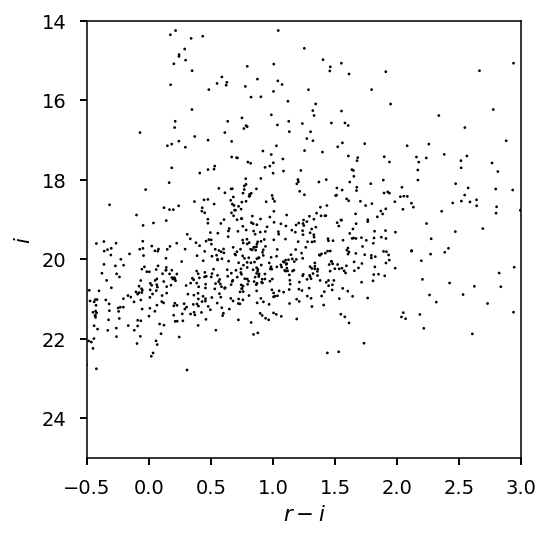

In [195]:
plt.style.use('seaborn-notebook')
plt.figure(1, figsize=(4, 4), dpi=140)
plt.title('Color-Magnitude Diagram for All Sources in Catalog')
plt.scatter(rMags - iMags,
                        iMags,
                        edgecolors='None', s=2, c='k')
#plt.xlim(-0.5, 3)
#plt.ylim(25, 14)
plt.xlabel('$r-i$')
plt.ylabel('$i$')
plt.subplots_adjust(left=0.125, bottom=0.1)
plt.show()

In [ ]:
rSources = butler.get('forced_src', {'filter': 'HSC-R', 'tract' : 0, 'patch' : '0,0'})
iSources = butler.get('forced_src', {'filter': 'HSC-I', 'tract': 0, 'patch': '1,1'})

In [ ]:
import astropy.io.fits as fitsio
hmm = fitsio.open('/home/jmyles/DATA/rerun/ccdForcedPhot/00533/HSC-R/tract0/FORCEDSRC-0903334-016.fits')
hmm2 = fitsio.open('/home/jmyles/DATA/rerun/ccdForcedPhot/00533/HSC-R/tract0/FORCEDSRC-0903334-022.fits')
hmm3 = fitsio.open('/home/jmyles/DATA/rerun/coaddForcedPhot/deepCoadd-results/HSC-R/0/0,1/forced_src-HSC-R-0-0,1.fits')

In [190]:
hmm[1].data.dtype.names

('flags',
 'id',
 'coord_ra',
 'coord_dec',
 'parent',
 'objectId',
 'parentObjectId',
 'deblend_nChild',
 'base_SdssCentroid_x',
 'base_SdssCentroid_y',
 'base_SdssCentroid_xSigma',
 'base_SdssCentroid_ySigma',
 'base_TransformedCentroid_x',
 'base_TransformedCentroid_y',
 'base_SdssShape_xx',
 'base_SdssShape_yy',
 'base_SdssShape_xy',
 'base_SdssShape_xxSigma',
 'base_SdssShape_yySigma',
 'base_SdssShape_xySigma',
 'base_SdssShape_x',
 'base_SdssShape_y',
 'base_SdssShape_flux',
 'base_SdssShape_fluxSigma',
 'base_SdssShape_psf_xx',
 'base_SdssShape_psf_yy',
 'base_SdssShape_psf_xy',
 'base_SdssShape_flux_xx_Cov',
 'base_SdssShape_flux_yy_Cov',
 'base_SdssShape_flux_xy_Cov',
 'base_TransformedShape_xx',
 'base_TransformedShape_yy',
 'base_TransformedShape_xy',
 'modelfit_DoubleShapeletPsfApprox_0_xx',
 'modelfit_DoubleShapeletPsfApprox_0_yy',
 'modelfit_DoubleShapeletPsfApprox_0_xy',
 'modelfit_DoubleShapeletPsfApprox_0_x',
 'modelfit_DoubleShapeletPsfApprox_0_y',
 'modelfit_DoubleS